# Iris Dataset Classification with apenet's Neural Network

This notebook demonstrates how to build, train, and evaluate a neural network model using the apenet library, using the Iris Dataset as an example.

## Import Libraries

In [23]:
import torch
## Data processing
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import our library
from apenet.nn.models.builder import ModelBuilder
from apenet.nn.train.trainer import Trainer
from apenet.nn.utils.data import train_test_split
from apenet.nn.loss.losses import CrossEntropyLoss
from apenet.nn.optimizers.optimizers import StochGradDescent

## Set device

In [24]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
print(f"Using device: {device}")

Using device: cpu


# Data Overview

## Load and Preprocess Data


In [25]:
# Load and preprocess data
iris = load_iris()
X = torch.tensor(iris.data, dtype=torch.float32, device=device)
y = torch.tensor(iris.target, dtype=torch.long, device=device)


## Data Visualization

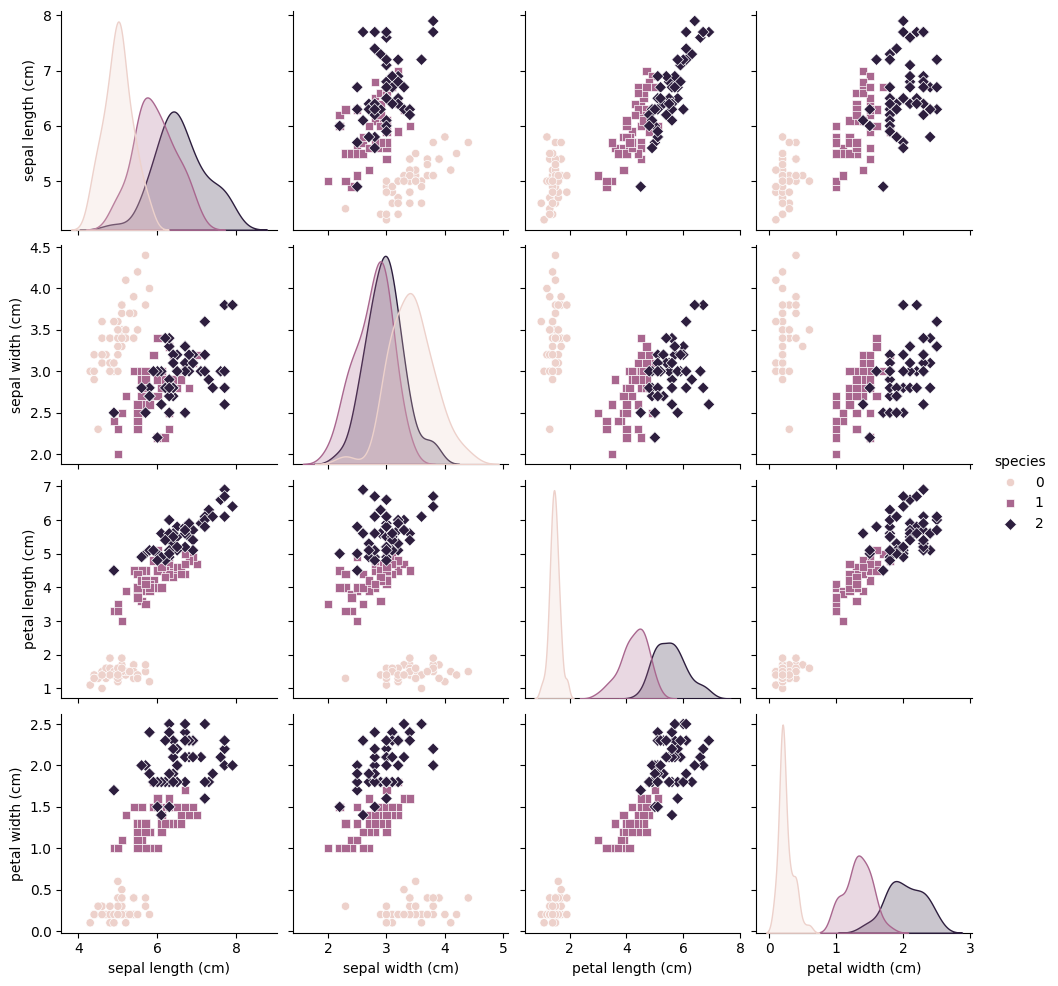

In [26]:
# Create a DataFrame for better visualization
df = pd.DataFrame(data=X, columns=iris.feature_names)
df['species'] = y

# Pairplot to visualize relationships between features
sns.pairplot(df, hue='species', markers=["o", "s", "D"])
plt.show()

## Data Preprocessing


In [27]:
# Standardize features
scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32, device=device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Model Overview

## Create Model


In [28]:
builder = ModelBuilder()
model = builder.build_mlp(
    input_size=X_train.shape[1],
    hidden_sizes=[16,8],
    output_size=3,
    hidden_activation='tanh',
    output_activation=None,
    initializer='Xavier'
)


## Define Loss Function and Optimizer


In [29]:
loss_fn = CrossEntropyLoss()
optimizer = StochGradDescent(model.get_parameters(), learning_rate=0.01)

## Create Trainer


In [30]:
# Create trainer
trainer = Trainer(model, loss_fn, optimizer)


## Train Model


In [31]:
# Train model
history = trainer.train(
    epochs=50,
    batch_size=16,
    verbose=10,
    X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test
)


Epoch 1/50: train_loss=1.1955, train_accuracy=0.2333, val_loss=1.2163, val_accuracy=0.2000
Epoch 11/50: train_loss=0.8223, train_accuracy=0.6417, val_loss=0.7797, val_accuracy=0.6667
Epoch 21/50: train_loss=0.6719, train_accuracy=0.8250, val_loss=0.6160, val_accuracy=0.8333
Epoch 31/50: train_loss=0.5752, train_accuracy=0.8583, val_loss=0.5178, val_accuracy=0.8667
Epoch 41/50: train_loss=0.5037, train_accuracy=0.8917, val_loss=0.4462, val_accuracy=0.8667
Epoch 50/50: train_loss=0.4535, train_accuracy=0.9000, val_loss=0.3989, val_accuracy=0.9667


## Evaluate Model


In [32]:
# Evaluate model
metrics = trainer.evaluate(X_test, y_test)
print(f"Test Loss: {metrics['loss']:.4f}, Test Accuracy: {metrics['accuracy']:.4f}")

Test Loss: 0.3989, Test Accuracy: 0.9667


## Plot Training History


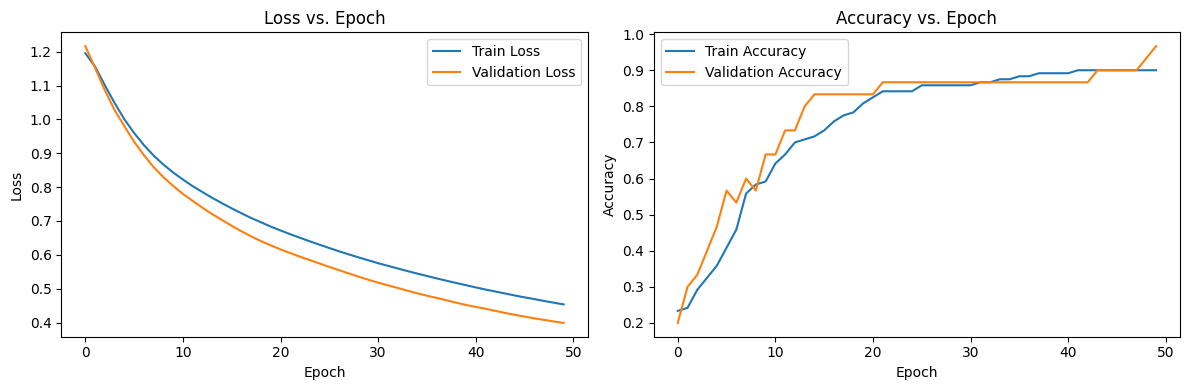

In [33]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ---- 1. Model Definition ----
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.Tanh(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.Tanh(),
            nn.Linear(hidden_sizes[1], output_size)  # no activation here
        )
        # Xavier initialization
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x)

model = MLP(
    input_size=X_train.shape[1],
    hidden_sizes=[16, 8],
    output_size=3
)

# ---- 2. Loss and Optimizer ----
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# ---- 3. Trainer Function ----
def train_model(model, optimizer, loss_fn, 
                X_train, y_train, X_val, y_val, 
                epochs=50, batch_size=16, verbose=10):
    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_ds = TensorDataset(X_val, y_val)
    val_dl = DataLoader(val_ds, batch_size=len(val_ds))

    history = {"loss":[], "val_loss":[], "val_acc":[]}
    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in train_dl:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            for Xv, yv in val_dl:
                val_preds = model(Xv)
                val_loss = loss_fn(val_preds, yv)
                val_acc = (val_preds.argmax(1) == yv).float().mean().item()
        train_loss = loss.item()  # last train batch

        history["loss"].append(train_loss)
        history["val_loss"].append(val_loss.item())
        history["val_acc"].append(val_acc)

        if epoch % verbose == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}: "
                  f"train loss {train_loss:.4f}, val loss {val_loss:.4f}, val acc {val_acc:.4f}")
    return history

# ---- 4. Train ----
history = train_model(
    model, optimizer, loss_fn,
    X_train, y_train, X_test, y_test,
    epochs=50, batch_size=16, verbose=10
)

Epoch   1: train loss 1.7334, val loss 1.9410, val acc 0.1000
Epoch  10: train loss 0.8849, val loss 0.7304, val acc 0.7333
Epoch  20: train loss 0.5529, val loss 0.4705, val acc 0.8000
Epoch  30: train loss 0.3957, val loss 0.3774, val acc 0.8333
Epoch  40: train loss 0.4067, val loss 0.3264, val acc 0.9333
Epoch  50: train loss 0.3263, val loss 0.2925, val acc 0.9667
